# Building a Dollar Cost Average Bot with the Alpaca Crypto API!

## What is Dollar Cost Averaging?

**The Basics**

Dollar cost averaging is one of the most popular strategies for buy-and-hold investors. Essentially, it involves buying a predetermined notional amount of an asset at specific intervals with no regard for where the price is at. By dollar cost averaging over a long enough time horizon, you'll be exposing yourself to all the troughs and peaks of the market cycle, with the hope that eventually the trend will be up and to the right.

**The Benefits of DCA**

Dollar cost averaging is often touted as the best way to build long term wealth for an average individual because it takes limited knowledge, almost no time commitment, and removes emotions from the equation. Simply buy the same amount of the asset every month, and you're set!

**The Setbacks of DCA**

Dollar cost averaging, while simple and effective, can leave returns on the table. Studies show that lump sum investing, or investing all your cash into the market at once, beats dollar cost averaging about 2/3rds of the time. Also, the asset in which you dollar cost average into (especially if it's an individual stock or cryptocurrency) always poses the risk of plummeting to 0 at any time so continually adding money to a sinking ship can be dangerous. This is where the limited knowledge of the investment class you're investing in can hurt.



## Using Alpaca to Dollar Cost Average into Ethereum

In this article, we'll first test out how a DCA strategy into Ethereum performs against a lump sum investment. Then, with that knowledge, we'll build a live market bot that DCAs into Ethereum over any specified timeframe!

**Download Dependencies**

First, we must pip install (download) all the required dependencies for the program. These dependencies are what make it possible to collect and calculate the data we need to test DCA historically and to build the trading bot.

In [ ]:
%%capture
!pip install alpaca_trade_api

**Import Modules**

Once we have downloaded the dependencies, we have to import them in order to use them in the program.

In [ ]:
# Import Dependencies
import time
import warnings
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
from alpaca_trade_api.rest import TimeFrame
warnings.filterwarnings("ignore", category=FutureWarning)

**Setup REST API**

In order to access paper trading from the Alpaca API, you must create an account and collect your API/secret keys. It's free and you can just sign up for a paper trading account!

In [ ]:
# Instantiate REST API
API_KEY = 'APCA-API-KEY-ID'
SECRET_KEY = 'APCA-API-SECRET-KEY'
rest_api = tradeapi.REST(API_KEY, SECRET_KEY,'https://paper-api.alpaca.markets')

## Historical Backtest of Lump Sum Investing vs Dollar Cost Averaging

**Define Variables and Retrieve Historical Data**

We must define the variables for the backtest which include the ticker, start date, and end date. Using these values, we can retrieve the historical pricing data for the cryptocurrency from the Coinbase exchange (CBSE).

In [ ]:
# Define crypto, start, and end dates
crypto = "ETHUSD"
num_of_years = 1
start_date = dt.datetime.today() - dt.timedelta(int(365 * num_of_years))
end_date = dt.datetime.today()

# Retrieve historical pricing for crypto
data = rest_api.get_crypto_bars(crypto, TimeFrame.Day, start_date.date(), end_date.date(), exchanges=['CBSE']).df
data_price = data['close']

**Simulate Historical Lump Sum Investing**

Next, we can create a function to lump sum invest. Essentially, we have to store the start date price and the end date price. Then, we can calculate the return if we held from the start to the end, and send the *investment_return* output back.

In [ ]:
# Simulate Historical Lump Sum Investing
def lumpsum_simulation(invest_date, principal=10000):
    invest_price = data.loc[invest_date]['close']
    current_price = data['close'][-1]
    investment_return = (current_price / invest_price) - 1

    return principal*(1+investment_return)

**Simulate Historical Dollar Cost Averaging Investing**

Now, we can create a function to dollar cost average over any given timeframe. As a parameter of the function, we defined the period to be 12 (months) times the number of years, and the frequency as 30 days. The starting principal is 10,000 dollars. So, in this particular scenario since the backtest is for 1 year, the bot is buying 8,333 dollars of Ethereum every month. 

In [ ]:
# Simulate Historical Dollar Cost Averaging
def dca_simulation(invest_date, periods=(12*num_of_years), freq='30D', principal=10000):
    dca_dates = pd.date_range(invest_date, periods=periods, freq=freq)
    dca_dates = dca_dates[dca_dates < data.index[-1]]

    cut_off_count = 12 - len(dca_dates)
    value = cut_off_count*(principal/periods)

    for date in dca_dates:
        trading_date = data.index[data.index.searchsorted(date)]
        value += lumpsum_simulation(trading_date, principal=principal/periods)
    return value

**How often does Lump Sum Investing beat DCA?**

Finally, we can simulate the lump sum investing as well as dollar cost averaging by running the functions in a for loop from the start date to the end date. This will give us a peek into how each strategy would've performed if it had started at any given day in the past year. Finally, we can create a new array with the difference in portfolio values between the strategies to see which one performed better.

Any value in the difference array that is positive indicates that the lump sum investing until that point would have outperformed dollar cost averaging. Given that information, we can find the percentage of time that lump sum investing beats dollar cost averaging by calculating how many times in the difference array that the value was positive. In this case, since Ethereum has been volatile over the past year, we can see that DCA has performed better about 63% of the time.

In [ ]:
# Create array of portfolio values from lump sum, dca, and the difference between the two
lump_sum = [lumpsum_simulation(x) for x in data.index]
dca = [dca_simulation(i) for i in data.index]
difference = np.array(lump_sum) - np.array(dca)

# Print statistics on how often Lump Sum Investing beat Dollar Cost Averaging
print("Lump Sum Investing Beats Dollar Cost Averaging {:.2f}% of the time".format((100*sum(difference>0)/len(difference))))

Lump Sum Investing Beats Dollar Cost Averaging 37.43% of the time


**Visualize Lump Sum and DCA Series of Equity Curves**

First, we can plot the price of Ethereum to get an idea of how it has performed over the past year. Next, we can plot the series of portfolio values for the lump sum investment strategy on every day in the past year. On the same plot, we can plot the same values but for the dollar cost average strategy.

We can see how the lump sum investment strategy returns heavily dependended on when you started investing. On the other hand, the DCA returns were relatively consistent regardless of the start date.

Finally, we can create an underwater plot to better visualize which strategy outperformed for what time period. Since August of 2021, we can see that DCA has largely outperformed lump sum investming for most of the time.

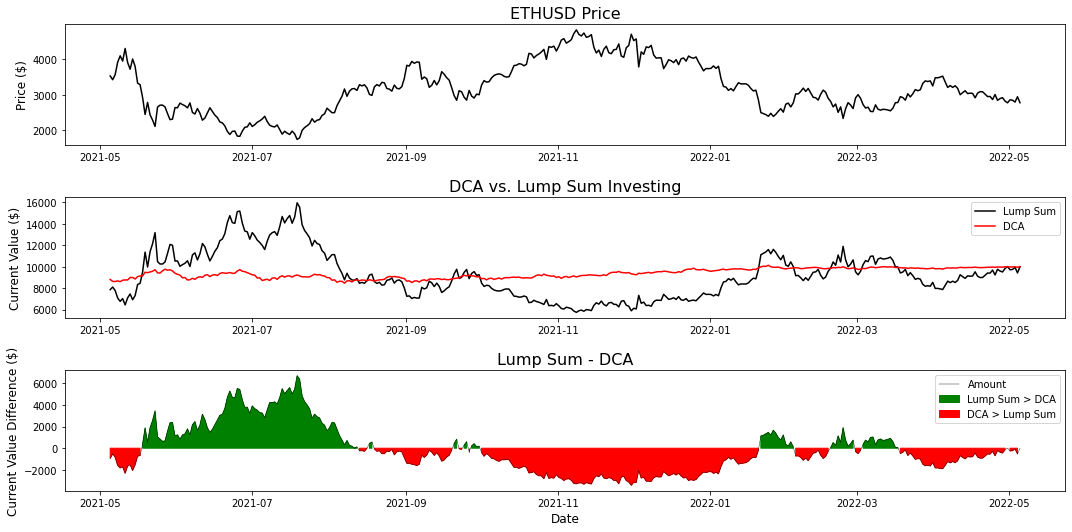

In [ ]:
# Plot crypto price, LS vs. DCA, and difference of returns
plt.rcParams['figure.figsize'] = 15, 7.5
fig, (ax1, ax2, ax3) = plt.subplots(3)

# Plotting crypto price
ax1.plot(data.index, data_price, color='black')
ax1.set_title(f'{crypto} Price', size=16)
ax1.set_ylabel('Price ($)', size=12)

# Plotting LS vs DCA equity curves
ax2.plot(data.index, lump_sum, color='black')
ax2.plot(data.index, dca, color='red')
ax2.set_title('DCA vs. Lump Sum Investing', size=16)
ax2.set_ylabel('Current Value ($)', size=12)
ax2.legend(['Lump Sum', 'DCA'])

# Plotting difference between LS and DCA equity curves
ax3.fill_between(data.index, y1=difference, y2=0, color='green', where=difference > 0, edgecolor='black')
ax3.fill_between(data.index, y1=difference, y2=0, color='red', where=difference < 0, edgecolor='black')
ax3.plot(data.index, difference, color='black', linewidth=.4)
ax3.set_title('Lump Sum - DCA', size=16)
ax3.set_ylabel('Current Value Difference ($)', size=12)
ax3.set_xlabel('Date', size=12)
ax3.legend(['Amount','Lump Sum > DCA', 'DCA > Lump Sum'])
fig.tight_layout()
plt.show()

## Live Dollar Cost Averaging Bot

Now that we've tested DCA vs Lump Sum Investing historically and seen the value of dollar cost averaging during volatile periods, we can get into creating a live DCA bot with Alpaca!

**Retrieve Account Balance**

Using the Alpaca REST API, we can retrieve the cash value in the account that we can use to DCA. Since we cannot use margin to buy cryptocurrency, we can specify specifically the non marginable buying power.

In [ ]:
# Retrieve Account Cash Balance (can only use non marginable buying power for crypto assets)
def get_cash_balance():
    cash = rest_api.get_account().non_marginable_buying_power
    return cash

**Retrieve Current Market Price**

Next, we can get the current market price for ethereum. By passing in the ticker, timeframe, and exchange (optional) into the *get_crypto_bars* method, Alpaca returns the historical pricing. We can turn the output into a dataframe by appending .df and then get the last bar of the "close" column.

In [ ]:
# Get current price for crypto
def get_current_price(crypto):
    price = (rest_api.get_crypto_bars(crypto, TimeFrame.Minute, exchanges=["CBSE"])).df["close"][-1]
    return price

**Placing Orders Through the Alpaca API**

Using the Alpaca REST API, we can submit orders to buy ethereum. In every order, we need to include the symbol, quantity or notional value, type of order (market or limit), side (buy or sell), and the time in force or how long the order should last if it is not filled immediately. For more information on buying/selling cryptocurrencies, you can check out https://alpaca.markets/learn/buying-crypto-using-alpaca-snapshot-and-crypto-apis/.

In [ ]:
# Place buy order through Alpaca API
def place_buy_order(quantity, crypto):
    rest_api.submit_order(symbol=crypto, qty=quantity, type="market", side="buy", time_in_force="day")
    return

**Create Dollar Cost Average Function**

We can create the function to execute retrieving the current ethereum price, updating the cash balance, and placing trades. Whenever this function is called, we can check if the cash available is greater than the predetermined position size. If that is the case, we can go ahead and buy a full position. Otherwise, we can use whatever cash is available to buy ethereum and print out that there was insufficient funds in the account. By wrapping the code in a try/except block, we can ensure the program does not quit running if an error is encountered.

In [ ]:
# Function to place orders when dollar cost averaging
def dollar_cost_average(crypto, position_size):
    try:
        currentPrice = float(get_current_price(crypto))
        print(f"\nThe current price for {crypto} is {currentPrice}")

        cash = float(get_cash_balance())
        print(f"The current cash balance available is {cash}")

        if cash > position_size:
            quantity = float(round(position_size / currentPrice, 3))
            print(f"{crypto} Buy Quantity: {quantity}")
            place_buy_order(quantity, crypto)

            time.sleep(1)
            print(f"The new cash balance is {get_cash_balance()}")
        else:
            print("Insufficient funds for full position")

            quantity = float(round((cash / currentPrice) * 0.95, 3))
            print(f"{crypto} Buy Quantity: {quantity}")
            place_buy_order(quantity, crypto)

            time.sleep(1)
            print(f"The new cash balance is {get_cash_balance()}")

        return {"Success": True}

    except Exception as e:
        print(e)
        return {"Success": False}

**Setup and Execution**

Lastly, we can finish the final pieces required to get the DCA bot up and running. First, we can ask the user for their preferred timeframe whether it be to DCA every day, week, or month. Next, we can ask what is the position size to use each time when we buy.

Using the timeframe input, we can translate that into a number of seconds for the time.sleep() function. The time.sleep() function will pause the program for any specified number of seconds.

Then, we can set a simple while True statement to keep the DCA bot running at all times. First, the program will run the dollar_cost_average function to buy ethereum, and then wait the specified timeframe to run the function once again. And that's it!

In [ ]:
# User input for timeframe, position sizing, cryptocurrency
timeframe = input("Enter DCA time frame (day, week, month): " )
position_size = float(input("Enter many dollars you want to buy of crypto per interval: "))
crypto = 'ETHUSD'

timeframe_to_seconds = {
    "day": 86400,
    "week": 604800,
    "month": 2629746
}

print(f"You have chosen to dollar cost average {position_size} of {crypto} every {timeframe}")

# Set up while statement to run DCA bot
while True:
    dollar_cost_average(crypto, position_size)
    time.sleep(timeframe_to_seconds[timeframe.lower()])

# Conclusion

Thanks for reading, and I hope you learned something about dollar cost averaging with the Alpaca Crypto API!